Short description:

I'm new to machine learning, and for my very first project, I've chosen a typical task in Supervised learning: predicting the target numeric value, in my case of a car, based on a given set of features, such as model, year, price, transmission, mileage, fuel type, tax, miles per gallon (mpg), and engine size. I'm building my solution based on the book 'Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow' by Aurélien Géron. The dataset I'm using can be found at the following link: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes?select=merc.csv. The author provides multiple .csv files in the archive, but I've opted to work with just one, named 'merc', which includes data for 13,119 different cars. To predict the approximate price of a car, I'll utilize a Supervised, Batch learning approach with a Model-based methodology. 


Firstly, we need to specify the required imports and set application constraints, ensuring a Python version equal to or greater than 3.5 and Scikit-Learn version equal to or greater than 0.20. Following that, default font sizes are configured, and a directory is defined along with a function to store our plots

In [1]:
import sys
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"


%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The next step is to download data from our .csv file into a Pandas DataFrame. We can use the head() method to display the first 5 rows of the .csv file.

In [ ]:
import pandas as pd

PROJECT_ROOT_DIR = os.getcwd()

def load_cars_data(project_root_dir=PROJECT_ROOT_DIR):
    csv_path = os.path.join(PROJECT_ROOT_DIR, "data/merc.csv")
    return pd.read_csv(csv_path)

In [6]:
cars = load_cars_data()
cars.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,SLK,2005,5200,Automatic,63000,Petrol,325,32.1,1.8
1,S Class,2017,34948,Automatic,27000,Hybrid,20,61.4,2.1
2,SL CLASS,2016,49948,Automatic,6200,Petrol,555,28.0,5.5
3,G Class,2016,61948,Automatic,16000,Petrol,325,30.4,4.0
4,G Class,2016,73948,Automatic,4000,Petrol,325,30.1,4.0


There are several non-numeric values such as model, transmission, and fuel type. We can analyze them using the value_counts() method. By taking 'model' as a parameter, we observe that there are 7 models with a count in the DataFrame less than or equal to 7. Consequently, it's not possible to make a reliable prediction using this data. I will remove those models from our DataFrame.

In [19]:
cars['model'].value_counts()

model
 C Class      3747
 A Class      2561
 E Class      1953
 GLC Class     960
 GLA Class     847
 B Class       591
 CL Class      511
 GLE Class     461
 SL CLASS      260
 CLS Class     237
 V Class       207
 S Class       197
 GL Class      121
 SLK            95
 CLA Class      86
 X-CLASS        82
 M Class        79
 GLS Class      74
 GLB Class      19
 G Class        15
 CLK             7
 CLC Class       3
 R Class         2
180              1
230              1
220              1
200              1
Name: count, dtype: int64

In [29]:
model_counts = cars['model'].value_counts()
models_to_remove = model_counts[model_counts <= 7].index.tolist()
cars = cars[~cars['model'].isin(models_to_remove)]

In [30]:
cars['model'].value_counts()

model
 C Class      3747
 A Class      2561
 E Class      1953
 GLC Class     960
 GLA Class     847
 B Class       591
 CL Class      511
 GLE Class     461
 SL CLASS      260
 CLS Class     237
 V Class       207
 S Class       197
 GL Class      121
 SLK            95
 CLA Class      86
 X-CLASS        82
 M Class        79
 GLS Class      74
 GLB Class      19
 G Class        15
Name: count, dtype: int64

<Axes: >

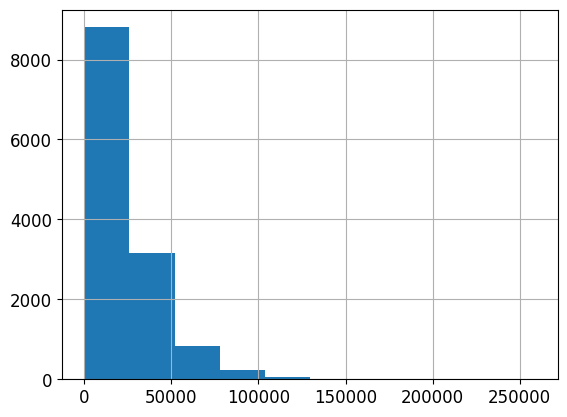

In [31]:
cars['mileage'].hist()

We can also use describe() method to see the summary of all numeric attributes. 

In [32]:
cars.describe()

,year,price,mileage,tax,mpg,engineSize
count,13103.000000,13103.000000,13103.000000,13103.000000,13103.000000,13103.000000
mean,2017.307487,24720.221323,21882.361215,129.775624,55.174975,2.071159
std,2.195876,11832.139128,21049.579411,64.907547,15.211428,0.571329
min,1970.000000,650.000000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,17466.000000,6069.000000,125.000000,45.600000,1.800000
50%,2018.000000,22480.000000,15175.000000,145.000000,56.500000,2.000000
75%,2019.000000,28980.000000,31717.000000,145.000000,64.200000,2.100000
max,2020.000000,159999.000000,259000.000000,580.000000,217.300000,6.200000


Final way to have a feel of our DataStructure is to plot a histogram of each numeric value. It is done to better understand the data you are dealing with.

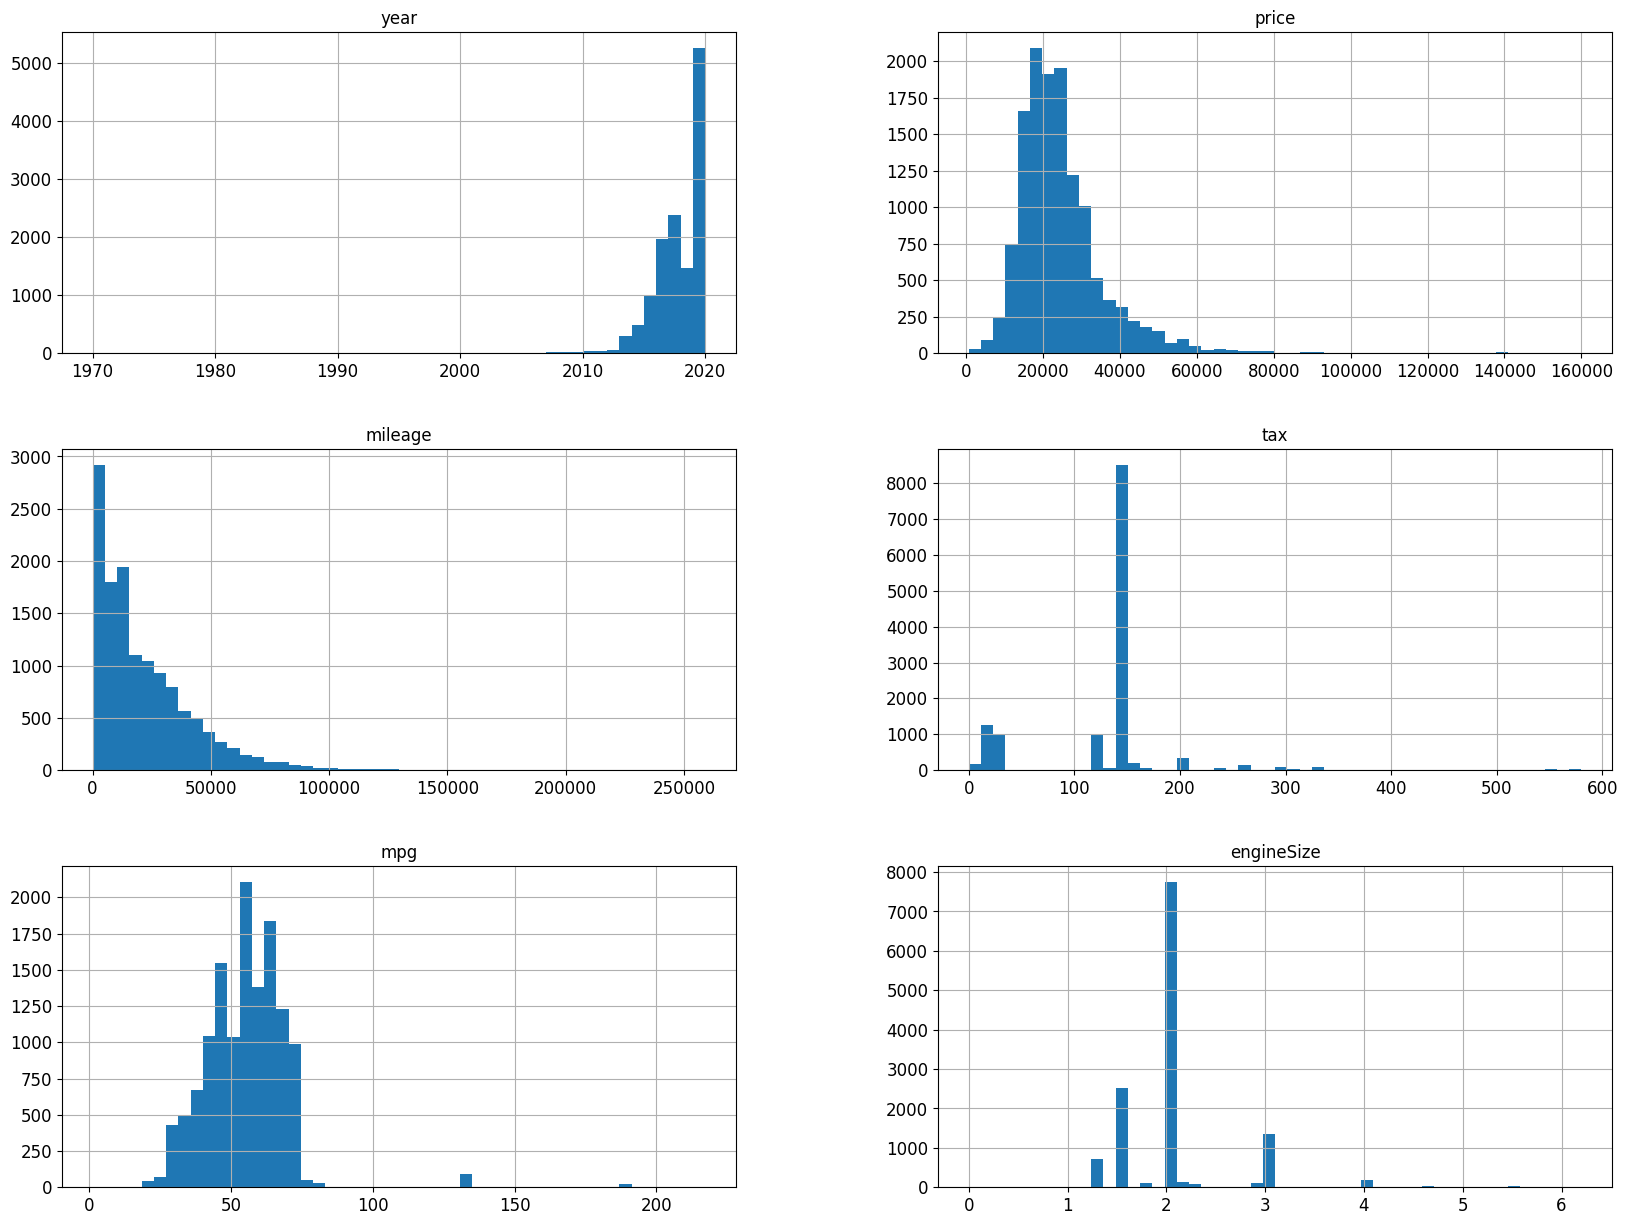

In [33]:
%matplotlib inline
cars.hist(bins=50, figsize=(20,15))
plt.show()

The next step is to create a test set. The main idea is that, if new values were ever appended to our dataset, the training set should remain unchanged. This separation allows us to assess the model's performance on unseen data, providing a reliable evaluation of its generalization capabilities. The easiest way to do so is to use train_set_split() function from sklearn library. The size of test set is usually 20% from the whole dataset, but it could be smaller in case dataset is huge.

C:\Users\vshug\AppData\Local\Temp\ipykernel_23264\3038674029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars['mileage_cat'] = pd.cut(cars['mileage'],


<Axes: >

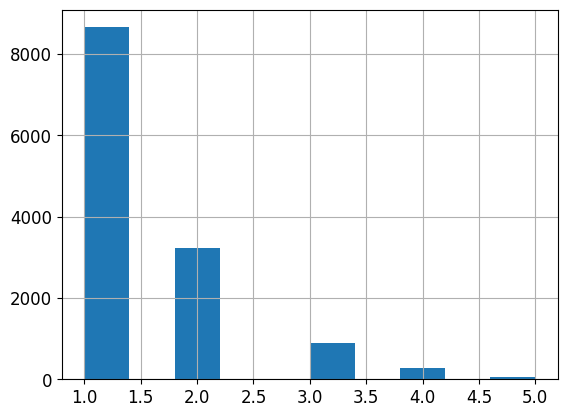

In [37]:
cars['mileage_cat'] = pd.cut(cars['mileage'],
                              bins=[0, 25000, 50000, 75000, 110000, np.inf],
                              labels=[1, 2, 3, 4, 5])

cars['mileage_cat'].hist()